In [1]:
######################################################################
# This function reads columns of a file. Copied from
# code.activestate.com/recipes/577444-get-columns-of-data-from-text-files/
######################################################################
def getColumnsAndIndexToName(inFile, delim=",", header=True):
    """
    Get columns of data from inFile. The order of the rows is respected
    
    :param inFile: column file separated by delim
    :param header: if True the first line will be considered a header line
    :returns: a tuple of 2 dicts (cols, indexToName). cols dict has keys that 
    are headings in the inFile, and values are a list of all the entries in that
    column. indexToName dict maps column index to names that are used as keys in 
    the cols dict. The names are the same as the headings used in inFile. If
    header is False, then column indices (starting from 0) are used for the 
    heading names (i.e. the keys in the cols dict)
    """
    cols = {}
    indexToName = {}
    for lineNum, line in enumerate(inFile):
        if lineNum == 0:
            headings = line.split(delim)
            i = 0
            for heading in headings:
                heading = heading.strip()
                if header:
                    cols[heading] = []
                    indexToName[i] = heading
                else:
                    #in this case the heading is actually just a cell
                    cols[i] = [heading]
                    indexToName[i] = i
                i += 1
        else:
            cells = line.split(delim)
            i = 0
            for cell in cells:
                cell = cell.strip()
                cols[indexToName[i]] += [cell]
                i += 1
                
    return cols, indexToName
#print(cols['Co'])
#print(indexToName)

######################################################################
# Returns columns of a csv file
######################################################################
def getColumns(fileName):
    file = open(fileName, "r")
    columns, indexToName = getColumnsAndIndexToName(file, delim=",")
    return columns

######################################################################
# Determines the min value of an array and the index.
######################################################################
def getMinAndIndex(list):
    #https://coderwall.com/p/a9hvrg/index-of-minimum-element-of-a-list
    #range for Python3, xrang for Python2
    minimun,index = min( (list[i],i) for i in range(len(list)) )
    return minimun, index

######################################################################
# Get the name of each column, in the head of the input file
######################################################################
def getKeys(fileName):
    columns = getColumns(fileName) ## csv format

    keys  = list( columns.keys() )
    A  = keys[0] # 'Co'
    B  = keys[1] # 'Ni'
    C  = keys[2] # "Ti"
    En = keys[3] # "Energy"
    iD = keys[4] # "conf_id"
    
    return A, B, C, En, iD

######################################################################
# Get minimum energy/atom of each set of pure configurations of Co,
# or Ni, or Ti only.
######################################################################
def getMinEnergyForPures(fileNamePures):
    A, B, C, En, iD = getKeys(fileNamePures) # strings!
    columns = getColumns(fileNamePures)

    # The configuration is A_{n1}B_{n2}C_{n3}
    list_nA = columns[A]
    list_nA = columns[A]
    list_nB = columns[B]
    list_nC = columns[C]
    lEnergy = columns[En]
   
    Aenergies = []
    Benergies = []
    Cenergies = []
    for i in range(len( lEnergy )):     
        if (list_nA[i] != '0'):
            Aenergies.append( float(lEnergy[i]) / float(list_nA[i]) )
        elif (list_nB[i] != '0'):
            Benergies.append( float(lEnergy[i]) / float(list_nB[i]) )
        elif (list_nC[i] != '0'):
            Cenergies.append( float(lEnergy[i]) / float(list_nC[i]) )
            
    minEnAperAtom, index = getMinAndIndex(Aenergies)
    minEnBperAtom, index = getMinAndIndex(Benergies)
    minEnCperAtom, index = getMinAndIndex(Cenergies)    

    return minEnAperAtom, minEnBperAtom, minEnCperAtom

######################################################################
# Reads columns of a csv file with a head:
######################################################################
def getPoints(fileName, numberOfPoints, fileNamePures):
    A, B, C, En, iD = getKeys(fileName) # strings!
    columns = getColumns(fileName)

    file = open("compositionVsFormationEntalphy.csv", "w")
    fileDat = open("datos.dat", "w")
    fileXYEDat = open("datosXYE", "w")
    
    file.write("Co, Ni, Ti, Energy, conf_id, FormationEntalphyPerAtom\n")

    
    cartesianPoints  = []
    triangularPoints = []
    IDs = []
    for i in range(numberOfPoints):
        #x = random.randint(1, scale)
        #y = random.randint(0, scale - x)
        #z = scale - x - y
        
        # The configuration is A_{nA}B_{nB}C_{nC}
        nA     = int(columns[A][i]) 
        nB     = int(columns[B][i])
        nC     = int(columns[C][i])
        nTotal = nA + nB + nC
    
        x = 100.0 * nA / nTotal
        y = 100.0 * nB / nTotal
        z = 100.0 * nC / nTotal
        cartesianPoints.append((x,y,z))
        IDs.append( columns[iD][i] )
              
        totalEnergy = float(columns[En][i])
        eA, eB, eC = getMinEnergyForPures(fileNamePures)
        energyBeforeReaction = (nA * eA) + (nB * eB) + (nC * eC) 
        deltaEnergy = totalEnergy - energyBeforeReaction
        formationEnergyPerAtom = deltaEnergy / nTotal
        
        s = "    "
        s = repr(x) + s + \
            repr(y) + s + \
            repr(formationEnergyPerAtom) + "\n"
        fileXYEDat.write(s)
        
        import math # importing "math" for mathematical operations
        x0 = x
        y0 = y
        x = x0 + (0.5 * y0)
        y = y0 * (math.sqrt(3.0) / 2.0)
        triangularPoints.append( (x, y, formationEnergyPerAtom) )
        
        s = ", "
        s = repr(nA) + s + \
            repr(nB) + s + \
            repr(nC) + s + \
            repr(totalEnergy) + s + \
            repr(columns[iD][i]) + s + \
            repr(formationEnergyPerAtom) + "\n"
        file.write(s)

        s = "    "
        s = repr(x) + s + \
            repr(y) + s + \
            repr(formationEnergyPerAtom) + "\n"
        fileDat.write(s)

    return cartesianPoints, triangularPoints, IDs

def Nan2Zero(matrix):
    matrixPandas = pd.DataFrame(matrix) # to Pandas
    matrixPandas = matrixPandas.fillna(0.0) # filling out possible NaN with zeros
    # returning back to the original shape. Without `.values` would give us a frame+pointValues
    return pd.DataFrame(matrixPandas).values 

def getIntComposition(fileName):
    A, B, C, En, iD = getKeys(fileName) # strings!
    columns = getColumns(fileName)
    
    intComposition = []
    for i in range(numberOfPoints):
        # The configuration is A_{nA}B_{nB}C_{nC}
        nA     = int(columns[A][i]) 
        nB     = int(columns[B][i])
        nC     = int(columns[C][i])
        intComposition.append( [nA,nB,nC] )
    
    return intComposition


In [3]:
fileName = "out.csv" #"outcopy.csv"
numberOfPoints = 195484 #195484
fileNamePures = "outPure.csv"

# print(getMinEnergyForPures(fileNamePures))
cartesianPoints, triangularPoints, IDs = getPoints(fileName, numberOfPoints, fileNamePures)

# triangularPoints

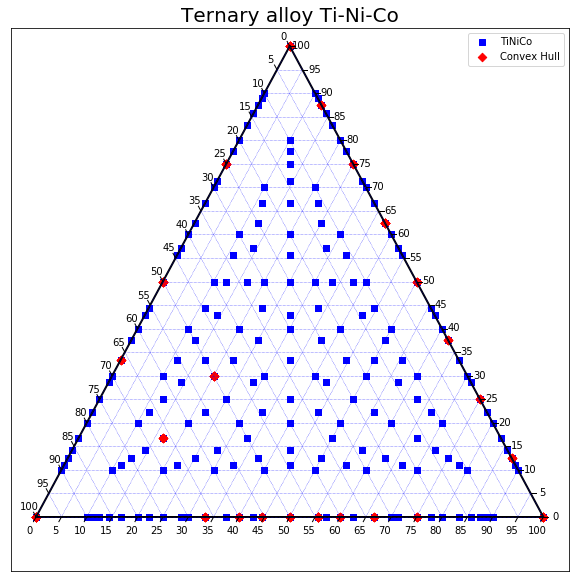

In [5]:

from scipy.spatial import ConvexHull
hull = ConvexHull(triangularPoints) # triangularPoints = (x,y,Energy)
# hull is full of indexes, not of points! (or better to say full of simplices?)
######################################################################

# Scatter Plot
scale = 100
import ternary
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 10)

tax.set_title("Ternary alloy Ti-Ni-Co", fontsize=20)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=5, color="blue")

######################################################################
#points = readPoints(10)
tax.scatter(cartesianPoints, marker='s', color='blue', label="TiNiCo")
######################################################################


######################################################################
hullXYZ = []
hullEnergies = []
hullTriangleE = []
hullIDs = []

for s in hull.simplices:
#     s = np.append(s, s[0])  # Here we cycle back to the first coordinate
#     print(s)
    i1 = s[0]
    i2 = s[1]
    i3 = s[2]
    hullXYZ.append( cartesianPoints[i1] ) # giving (x,y,z): %-composition of Co,Ni,Ti = 100%
    hullXYZ.append( cartesianPoints[i2] ) # giving (x,y,z) of the second vertex of the simplex
    hullXYZ.append( cartesianPoints[i3] ) # giving (x,y,z) of the third vertex of the simplex
    hullEnergies.append( triangularPoints[i1][2] ) # giving Energy of the first vertex of the simplex
    hullEnergies.append( triangularPoints[i2][2] ) # giving Energy of the second vertex of the simplex
    hullEnergies.append( triangularPoints[i3][2] )
    hullIDs.append( IDs[i1] ) # ID of the first vertex
    hullIDs.append( IDs[i2] ) # ID of the second vertex
    hullIDs.append( IDs[i3] ) # ID of the third vertex

tax.scatter(hullXYZ, marker='D', color='red', label="Convex Hull") #scatter receive Cartesian coordinates!
######################################################################

tax.legend()
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()


In [18]:
def getVerticesFromSimplex(simplex, listPoints):
    r1 = listPoints[simplex[0]] # first point
    r2 = listPoints[simplex[1]] # second point
    r3 = listPoints[simplex[2]] # third point
    return r1, r2, r3

def getBarycenter(r1, r2, r3):
    # r1, r2, and r3 are vectors, then the position of the barycenter is:
    x = r1[0] + r2[0] + r3[0]
    y = r1[1] + r2[1] + r3[1]
    z = r1[2] + r2[2] + r3[2]
    barycenter = [x / 3.0, y / 3.0, z / 3.0]
    return barycenter

# a simplex is a set of 3 integers, each one associate a one point p.
def getBarycenterOfCartesianSimplex(simplex, cartesianPoints):
    [r1, r2, r3] = getVerticesFromSimplex(simplex, cartesianPoints)
    barycenter = getBarycenter(r1, r2, r3) # barycenter is a vector [x,y,z]
    return barycenter

def belongs(x, xmin, xmax):
    return (xmin <= x) and (x <= xmax)
    
def hypotenuseWall(x,lenghtLegA, lenghtLegB): ## would depend of the length of the legs (catetos)
    #  |_\  : legA, legB, hypotenuse
    # (x,y)/(x0,y0) = (-legA/legB), where (x0,y0)=(b,0)
    y = (-lenghtLegA / lenghtLegB) * (x - lenghtLegB)
    return y 
    
def isBarycenterAtCartesianWalls(barycenter):
    x = barycenter[0]
    y = barycenter[1]
    
    eps = 0.1
    lengthLeg = 100

    isSimplexInXwall = belongs(x, -eps, eps)
    isSimplexInYwall = belongs(y, -eps, eps)
    
    yHypotenuse = hypotenuseWall(x, lengthLeg, lengthLeg)
    isSimplexInHyponeuseWall = belongs(y, yHypotenuse - eps, yHypotenuse + eps)

    # if simplex belongs to X-wall, but do not touches the Y-wall:
    # if simplex belongs to Y-wall, but do not touches the X-wall:
    # if simplex belongs to "hypotenuse", but do not touches the X-wall nor the Y-wall:        
#     if (    ( isSimplexInXwall and !isSimplexInYwall and !isSimplexInHyponeuseWall )    \
#         or  ( isSimplexInYwall and !isSimplexInXwall and !isSimplexInHyponeuseWall )    \
#         or  ( isSimplexInHyponeuseWall and  !isSimplexInXwal and !isSimplexInYwal  )  ):
#         return true

    if ( (         isSimplexInXwall   \
          and (not isSimplexInYwall)  \
          and (not isSimplexInHyponeuseWall) )  \
       or \
         (         isSimplexInYwall   \
          and (not isSimplexInXwall)  \
          and (not isSimplexInHyponeuseWall) )  \
       or \
         (         isSimplexInHyponeuseWall     \
          and (not isSimplexInXwall)   \
          and (not isSimplexInYwall) ) \
       ):
        return True
    
    return False
 
def isEnergyAbove(energy):
    # it would need improvement of the idea here...
    reference = 0.012 #0.02
    eps = 0.01
    emin = reference - eps
    emax = reference + 10
    if ( belongs(energy, emin, emax) ):
        return True
    return False

def getStringComposition(nListComposition, stringA, stringB, stringC):
    # nListComposition = [n_A, n_B, n_C]
    [nA, nB, nC] = nListComposition
    
    chemFormula = ""
    if (nA != 0):
        if (nA == 1):
            chemFormula += stringA
        else:
            chemFormula += stringA + repr(nListComposition[0])
    if (nB != 0):
        if (nB == 1):
            chemFormula += stringB
        else:
            chemFormula += stringB + repr(nListComposition[1])
    if (nC != 0):
        if (nC == 1):
            chemFormula += stringC
        else:
            chemFormula += stringC + repr(nListComposition[2])    
    
    return chemFormula

[24911 12756  2225]
[168762  12756   2225]
[168762 188790  12756]
[180954 188790  12756]
[180954  66041  12756]
[52333 24911  2225]
[52333  9930 24911]
[22156  9930 70995]
[22156 95460 70995]
[22156 95460 24911]
[22156  9930 24911]
 
[24911, 168762, 168762, 180954, 180954, 52333, 52333, 22156, 22156, 22156, 22156]
[12756, 12756, 188790, 188790, 66041, 24911, 9930, 9930, 95460, 95460, 9930]
[2225, 2225, 12756, 12756, 12756, 2225, 24911, 70995, 70995, 24911, 24911]
 
['Ni4Ti4', 'Ni6Ti2', 'Co5Ti5', 'Co4Ti2', 'Ni6Ti2', 'Co5Ti5', 'Co4Ti2', 'Co6Ti2', 'Ni6Ti2', 'Co2', 'Co6Ti2', 'Ni6Ti2', 'Co2', 'Ni', 'Ni6Ti2', 'Co4Ti6', 'Ni4Ti4', 'Co5Ti5', 'Co4Ti6', 'Co2Ti4', 'Ni4Ti4', 'CoNiTi4', 'Co2Ti4', 'Ti2', 'CoNiTi4', 'Ni2Ti4', 'Ti2', 'CoNiTi4', 'Ni2Ti4', 'Ni4Ti4', 'CoNiTi4', 'Co2Ti4', 'Ni4Ti4']
 


[[24913, 'Ni4Ti4', 'bcc7611'],
 [12758, 'Ni6Ti2', 'bcc8610'],
 [2227, 'Co5Ti5', 'bcc35601'],
 [168764, 'Co4Ti2', 'hcp416'],
 [12758, 'Ni6Ti2', 'bcc8610'],
 [2227, 'Co5Ti5', 'bcc35601'],
 [168764, 'Co4Ti2', 'hcp416'],
 [188792, 'Co6Ti2', 'fcc9150'],
 [12758, 'Ni6Ti2', 'bcc8610'],
 [180956, 'Co2', 'hcp1'],
 [188792, 'Co6Ti2', 'fcc9150'],
 [12758, 'Ni6Ti2', 'bcc8610'],
 [180956, 'Co2', 'hcp1'],
 [66043, 'Ni', 'fcc2'],
 [12758, 'Ni6Ti2', 'bcc8610'],
 [52335, 'Co4Ti6', 'bcc55405'],
 [24913, 'Ni4Ti4', 'bcc7611'],
 [2227, 'Co5Ti5', 'bcc35601'],
 [52335, 'Co4Ti6', 'bcc55405'],
 [9932, 'Co2Ti4', 'hcp361'],
 [24913, 'Ni4Ti4', 'bcc7611'],
 [22158, 'CoNiTi4', 'hcp490'],
 [9932, 'Co2Ti4', 'hcp361'],
 [70997, 'Ti2', 'hcp6'],
 [22158, 'CoNiTi4', 'hcp490'],
 [95462, 'Ni2Ti4', 'hcp504'],
 [70997, 'Ti2', 'hcp6'],
 [22158, 'CoNiTi4', 'hcp490'],
 [95462, 'Ni2Ti4', 'hcp504'],
 [24913, 'Ni4Ti4', 'bcc7611'],
 [22158, 'CoNiTi4', 'hcp490'],
 [9932, 'Co2Ti4', 'hcp361'],
 [24913, 'Ni4Ti4', 'bcc7611']]

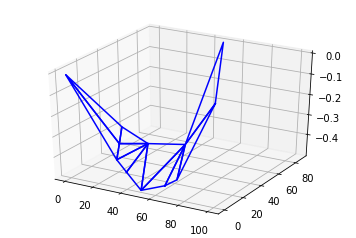

In [19]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pts =  np.array(triangularPoints)

elementA = "Co"
elementB = "Ni"
elementC = "Ti"

iList = []
jList = []
kList = []
xList = []
yList = []

# fileName = "outcopy.csv"        
intComposition = getIntComposition(fileName)
# nCompositionHull = []
listChemFormula = []
listIDs = []
listLines = []


# file = open("indicesConvexHull.dat", "w")
for s in hull.simplices:
#     s = np.append(s, s[0])  # Here we cycle back to the first coordinate
#     print(s)
    barycenter = getBarycenterOfCartesianSimplex(s, cartesianPoints)

    # it would need to improve the idea here, since I just take the energy of any vertix simplex
    energyTop = triangularPoints[s[0]][2] 
   
    if (    (not isBarycenterAtCartesianWalls(barycenter)) \
        and (not isEnergyAbove(energyTop))   ):
        print(s)
        i = s[0] # first vertex
        j = s[1] # second vertex
        k = s[2] # third vertex of a simplex `s`
        
        s = np.append(s, s[0])  # Here we cycle back to the first coordinate
        ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")  

        iList.append(i) # first vertex
        jList.append(j) # second vertex
        kList.append(k) # third vertex of a simplex `s`
        
        [nCo, nNi, nTi] = [intComposition[i][0], intComposition[i][1], intComposition[i][2] ]
#         nCompositionHull.append( [nCo, nNi, nTi] )
        listChemFormula.append( getStringComposition([nCo, nNi, nTi], elementA, elementB, elementC) ) 
        listIDs.append( IDs[i] )
        listLines.append(i)

        
        [nCo, nNi, nTi] = [intComposition[j][0], intComposition[j][1], intComposition[j][2] ]
#         nCompositionHull.append( [nCo, nNi, nTi] )        
        listChemFormula.append( getStringComposition([nCo, nNi, nTi], elementA, elementB, elementC) )
        listIDs.append( IDs[j] )
        listLines.append(j)
        
        [nCo, nNi, nTi] = [intComposition[k][0], intComposition[k][1], intComposition[k][2] ]
#         nCompositionHull.append( [nCo, nNi, nTi] )
        listChemFormula.append( getStringComposition([nCo, nNi, nTi], elementA, elementB, elementC) )
        listIDs.append( IDs[k] )
        listLines.append(k)
        
        
print(" ")    
print(iList)
print(jList)
print(kList)

print(" ")
# print(nCompositionHull)
print(listChemFormula)
print(" ")

chemAndID = [ [listLines[i]+1+1, listChemFormula[i], listIDs[i] ] for i in range(len(listChemFormula))  ]
# "+1": due to headLine
# "+1": due to the fact that Python begins to count from "0", not from "1"

chemAndID




In [20]:




import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
import math

Emin = -0.5
Emax = 0.2
ym = math.sqrt(3.0) / 2.0

# xList = pts[:,0]
# yList = pts[:,1]
# zList = pts[:,2]
xList = []
yList = []
zList = []
for i in range(0, len(pts)):
    xList.append(triangularPoints[i][0] / 100)
    yList.append(triangularPoints[i][1] / 100)
    zList.append(triangularPoints[i][2])



trace2 = go.Mesh3d(
        x = xList,
        y = yList,
        z = zList,
        cmin = Emin,
        cmax = Emax,
        opacity = 0.4,
        colorbar = go.ColorBar(
            title='Formation Entalphy\n(eV/atom)',
            titleside = "bottom",
        ),
#         colorscale = [['0', 'rgb(255, 0, 0)'], 
#                       ['0.5', 'rgb(0, 255, 0)'], 
#                       ['1', 'rgb(0, 0, 255)']],
        colorscale='Jet',
#         colorscale='Viridis',
        intensity = zList,
        i = iList,
        j = jList,
        k = kList,
        lighting=dict(ambient=1.0, diffuse=1.0,
                           specular=0.0, roughness=1.0,
                           fresnel=0.0)
        #name = 'z',
        #showscale = True
        
    )
    

    
    
    

    
    
    
# line_pts=[]

    
line_pts=[]
list_annotations = []
# j = 0


for i in range(0,len(iList)):
    '''    
    x.append( triangularPoints[s[0]][0] )
    y.append( triangularPoints[s[0]][1] )
    z.append( triangularPoints[s[0]][2] ) 
    
    x.append( triangularPoints[s[1]][0] )
    y.append( triangularPoints[s[1]][1] )
    z.append( triangularPoints[s[1]][2] )
    
    x.append( triangularPoints[s[2]][0] )
    y.append( triangularPoints[s[2]][1] )
    z.append( triangularPoints[s[2]][2] )

    x.append( triangularPoints[s[0]][0] )
    y.append( triangularPoints[s[0]][1] )
    z.append( triangularPoints[s[0]][2] )
    '''
    
    x = []
    y = []
    z = []
   
    x.append( xList[ iList[i] ]  )
    y.append( yList[ iList[i] ]  )
    z.append( zList[ iList[i] ]  )

    x.append( xList[ jList[i] ]  )
    y.append( yList[ jList[i] ]  )
    z.append( zList[ jList[i] ]  )    

    x.append( xList[ kList[i] ]  )
    y.append( yList[ kList[i] ]  )
    z.append( zList[ kList[i] ]  )    

    x.append( xList[ iList[i] ]  )
    y.append( yList[ iList[i] ]  )
    z.append( zList[ iList[i] ]  )
    
    line_pts.append(  go.Scatter3d(
                            x=x,
                            y=y,
                            z=z,
#                             mode = 'lines',
                            mode='lines+markers',
                            line=dict(color='#000000', width=3),
                            marker=dict(
                                cmin = Emin,
                                cmax = Emax,
                                size=5,
                                color=z,                                
#                                 color=[1,1,1],                # set color to an array/list of desired values
                                colorscale='Jet',   # choose a colorscale
                                opacity=1,
                                # I do not know why, but colors are correct related if width=2
                                #         line=dict(width=2, color='rgb(204, 204, 204)' ), 
                                ),
                            showlegend=False
                            )                    
                    )
    
    for j in range(3): #0,1,2
        list_annotations.append(
            dict(
               showarrow = False,
               x = x[j],
               y = y[j],
               z = z[j],
               text = listChemFormula[ (3 * i) + j],
               xanchor = "left",
               xshift = 8,
               opacity = 1.0,
              ),
            )
    
            
    






trace6 = go.Scatter3d(
                            showlegend=False,
                            x=[0, 1, 0.5,  0,       0,1,0.5,0,  0, 1, 0.5, 0,        1,   1,   0.5, 0.5   ],
                            y=[0, 0, ym,   0,       0,0,ym, 0,  0, 0,  ym, 0,        0,   0,   ym,   ym   ],
                            z=[Emax,Emax,Emax,Emax, 0,0,0,  0,  Emin,Emin,Emin,Emin, Emin,Emax,Emax,Emin  ],
    
                            mode='lines',
                            line=dict(color='#000000'),    
                            marker=dict(
                                size=8,
#                                 color=[1,1,1],                # set color to an array/list of desired values
#                                 colorscale='Jet',   # choose a colorscale
                                opacity=1,
                                # I do not know why, but colors are correct related if width=2
                                #         line=dict(width=2, color='rgb(204, 204, 204)' ), 
                                )
                            
)


trace3 = go.Scatter3d(
    showlegend=False,
    x=xList,
    y=yList,
    z=zList,
    mode='markers',
    marker=dict(
        cmin = -0.5,
        cmax = 0.2,
        size=1.5,
        color=zList,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.9,
        # I do not know why, but colors are correct related if width=2
#         line=dict(width=2, color='rgb(204, 204, 204)' ), 
    )
)


data = [ trace2, trace6, trace3] + line_pts
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
#         b=0,
        t=0
    ),

    scene = dict(
        xaxis = dict( title = "Co", visible = False,
#           type = "log"
        ),        
        yaxis = dict( title = "Ni", visible = False,
        ),
        zaxis = dict( title = "Entalphy formation (meV)", showgrid=False, visible =False,
        ),
       camera = dict(
           up=dict(x=1, y=0, z=0),
           center=dict(x=0, y=0, z=0),
           eye=dict(x=0.0, y=0.0, z=-2),
        ),
                     
        annotations = list_annotations 

    
      ),
)
    
    

    

    
fig = go.Figure(data=data, layout=layout)

# iplot(fig, filename='3d-CoNiTi.html')



from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plot(fig, filename='3d-CoNiTi.html')

'file:///Users/chinchay/Documents/2_codes/afterRunning/3/3d-CoNiTi.html'

In [549]:
import math
def norma(v):
    return (v[0] * v[0]  +  v[1] * v[1]) ** 0.5

def dot(v1, v2):    
    return v1[0] * v2[0]  +  v1[1] * v2[1]

def determinant(v, w):
    return v[0]*w[1]-v[1]*w[0]

def isNE2D(v, w):
    eps = 0.0001
    return (  ( not belongs(v[0], w[0] - eps, w[0] + eps) ) or\
              ( not belongs(v[1], w[1] - eps, w[1] + eps) )     )

def getAngleClockwise(v1, v2, vc): # v's are 3D vectors, but only XY-components will be considered
#https://stackoverflow.com/questions/31735499/calculate-angle-clockwise-between-two-points
    vA = [v1[0] - vc[0], v1[1] - vc[1]]
    vB = [v2[0] - vc[0], v2[1] - vc[1]]
    det = determinant(vA,vB)
    cosAngle = dot(vA, vB) / (norma(vA) * norma(vB))
    
    if (abs(cosAngle) > 1.0):
#         print("cosAngle = ", cosAngle)
#         print(dot(vA, vB))
#         print(norma(vA))
#         print(norma(vB))
#         print(norma(vA) * norma(vB))
        dAngle = abs(cosAngle) - 1.0
        if (dAngle > 0.001):
            print("there is something wrong here.")
        else:
            cosAngle = np.sign(cosAngle) * 1.0
#         print("new approximation for cosAngle = ", cosAngle) 
#         print(" ")
        

#     print(v1,v2,vc)
    
    innerAngle = math.acos(cosAngle) # in radians

    if det < 0: #this is a property of the det. If the det < 0 then B is clockwise of A
        return  2* math.pi - innerAngle
        
    else: # if the det > 0 then A is immediately clockwise of B
        return innerAngle

def isLEthanPi(angle):
    return ( angle <= math.pi )
    
def isInsideProjectedXYTriangle(v1, v2, v3, vc): #v's are 3D vectors
    if ( isNE2D(v1,vc) and isNE2D(v2,vc) and isNE2D(v3,vc) ):
        alpha = getAngleClockwise(v1, v2, vc) # calculated on the xy-projected vectors
        beta  = getAngleClockwise(v2, v3, vc) # calculated on the xy-projected vectors
        gamma = getAngleClockwise(v3, v1, vc) # calculated on the xy-projected vectors
#     print(alpha * 180 / math.pi) 
#     print(beta * 180 / math.pi) 
#     print(gamma * 180 / math.pi) 
        if ( isLEthanPi(alpha) and isLEthanPi(beta) and isLEthanPi(gamma) ):
            return True
        else:
            return False
    else: # vc is one point belonging to the convex Hull: v1,v2, or v3
        return True
    
import numpy as np
from scipy.spatial import distance
#https://stackoverflow.com/questions/30088697/4-1-2-numpy-array-sort-clockwise
#Numpy Array Sort Clockwise
def sortpts_clockwise(A):
    # Sort A based on Y(col-2) coordinates
    sortedAc2 = A[np.argsort(A[:,1]),:]

    # Get top two and bottom two points
    top2 = sortedAc2[0:2,:]
    bottom2 = sortedAc2[2:,:]

    # Sort top2 points to have the first row as the top-left one
    sortedtop2c1 = top2[np.argsort(top2[:,0]),:]
    top_left = sortedtop2c1[0,:]

    # Use top left point as pivot & calculate sq-euclidean dist against
    # bottom2 points & thus get bottom-right, bottom-left sequentially
    sqdists = distance.cdist(top_left[None], bottom2, 'sqeuclidean')
    rest2 = bottom2[np.argsort(np.max(sqdists,0))[::-1],:]

    # Concatenate all these points for the final output
    return np.concatenate((sortedtop2c1,rest2),axis =0)

def sortVectorsClockwise(v1,v2,v3):
    A = np.array([v1,v2,v3])
    sort = sortpts_clockwise(A)
    v1 = [ sort[0][0], sort[0][1], sort[0][2] ]
    v2 = [ sort[1][0], sort[1][1], sort[1][2] ]
    v3 = [ sort[2][0], sort[2][1], sort[2][2] ]
    return v1, v2, v3


def solve2D(u1, u2, v):
    #https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html
    #Solve the system of equations 3*t1 +   t2 = 9
    #                          and   t1 + 2*t2 = 8:
    # a = np.array([[3,1], [1,2]])
    # b = np.array([9,8])
    # x = np.linalg.solve(a, b)
    #
    # Solving in 2D: u1*t1 + u2*t2 = v
    # where u1, u2, and v are known
    [m, n] = u1
    [p, q] = u2
    [r, s] = v

#     print("u1,u2,v=", u1,u2,v)
    
    a = np.array([[m,p], [n,q]])
    b = np.array([r,s])
    x = np.linalg.solve(a, b) ## x is a 2D vector!
    [t1, t2] = x
    return t1, t2

def getUnitVector(v):
    normaV = norma(v)
    u = [ v[0] / normaV, v[1] / normaV, v[2] / normaV ]
    return u

def getXYprojectedVector(v):
    vXY = [v[0], v[1]] # v has x,y,z components!
    return vXY

# vStr = [x,y,Energy] of a configuration, in cartesian coordinates.
def getEnergyCrossingHullSurface(v1, v2, v3, vConfig):
#     A = v2 - v1
#     B = v3 - v1
#     print(v1, v2, v3)
    A = [v2[0] - v1[0], v2[1] - v1[1], v2[2] - v1[2]]
    B = [v3[0] - v1[0], v3[1] - v1[1], v3[2] - v1[2]]    
    [x, y, zTemp] = vConfig # zTemp is not going to be used here.
    
    # this function finds Eh in the vectorial equation: 
    # [x,y,Eh] = v1 + unitVector(A)*t1 + unitVector(B)*t2; t1,t2 are Reals
    # First, we find t1 and t2 by solving a system of two equations
    # embedded in the XY-components of the vectorial equation:
    # [x,y] = v1 + u2D_A*t1 + u2D_B*t2, to find t1,t2,
    # but we can reduce by doing:
    rxy = [x - v1[0], y - v1[1]]
    # So now, we need to solve rxy = u2D_A*t1 + u2D_B*t2, to find t1,t2
    
    # building the unit vectors:
    uA = getUnitVector(A)
    uB = getUnitVector(B)
    
    # proyecting into the XY-plane:
    u2D_A = getXYprojectedVector(uA)
    u2D_B = getXYprojectedVector(uB)
    
    # finding t1,t2 that solves rxy = u2D_A*t1 + u2D_B*t2  
    t1, t2 = solve2D(u2D_A, u2D_B, rxy)
    
    # now we can find Eh in the original vector 3D equation:
    # [x,y,Eh] = v1 + unitVector(A)*t1 + unitVector(B)*t2; t1,t2 are Reals
    Eh = v1[2] + (uA[2] * t1) + (uB[2] * t2)
    return Eh
    



    

In [595]:
deltaE = 0.001 #0.001;
nConfigSamples = numberOfPoints # #numberOfPoints

#------------------------------------

IDs_in_dE = []
triangularPointsdE = []
dic_ID_chem_dE = {}
dic_ID_diffE_dE = {}
dic_ID_eHull = {}
dic_ID_energyFormation = {}

# %Co -> x-cartesian
# %Ni -> y-cartesian
# energy -> z-cartesian
cartesianEnergyPoints = [ (cartesianPoints[i][0], \
                           cartesianPoints[i][1], \
                           triangularPoints[i][2])\
                           for i in range(numberOfPoints) \
                        ]
j = 0
print("j_simplex = ", end = "")
for s in hull.simplices:
    j = j + 1
#     print("j_simplex = ", j)
    print(j, end = "")
    print(", ", end = "")

    barycenter = getBarycenterOfCartesianSimplex(s, cartesianPoints)

    # it would need to improve the idea here, since I just take the energy of any vertix simplex
    energyTop = triangularPoints[s[0]][2] 
   
    # this will avoid simplexes belonging to the walls, and also will
    # avoid problems with singularities when trying
    # to use solve2D() in getEnergyCrossHullSurface():
    if (    (not isBarycenterAtCartesianWalls(barycenter)) \
        and (not isEnergyAbove(energyTop))   ):
        
        r1, r2, r3 = getVerticesFromSimplex(s, cartesianEnergyPoints)
        v1, v2, v3 = sortVectorsClockwise(r1, r2, r3)
        for i in range(nConfigSamples):
            x, y, energyFormation = cartesianEnergyPoints[i]
            rConfig = [x, y, energyFormation]
    
            if ( isInsideProjectedXYTriangle(v1, v2, v3, rConfig) ):
                eCrossHull = getEnergyCrossingHullSurface(v1, v2, v3, rConfig)
#                 print("i, j_simplex = ", i,j)
                dE = energyFormation - eCrossHull
                if (abs(dE) < deltaE):
                    IDs_in_dE.append(IDs[i])
                
                    triangularPointsdE.append(triangularPoints[i])
                
                    [nCo, nNi, nTi] = [intComposition[i][0], intComposition[i][1], intComposition[i][2] ]
                    chem = getStringComposition([nCo, nNi, nTi], elementA, elementB, elementC) 
                    dic_ID_chem_dE[ IDs[i]  ] =  chem
                    dic_ID_diffE_dE[ IDs[i] ] = dE - deltaE
                    dic_ID_eHull[ IDs[i] ] = eCrossHull
                    dic_ID_energyFormation[ IDs[i] ] = energyFormation
                    
    # configs at the wall were alredy included, because they can be projected to
    # a simplex that are not on the wall!
            

# "set" will do UNION (avoiding repetition),
# and "list" will convert the result {} into a list [].
IDs_in_dE = sorted( list( set( IDs_in_dE ) ) )
IDsChemdE = [ [ ID, dic_ID_chem_dE.get(ID), dic_ID_diffE_dE.get(ID), \
                dic_ID_eHull.get(ID), dic_ID_energyFormation.get(ID)] for ID in IDs_in_dE ]


print("\nthere are ", len(IDs_in_dE), "configs in deltaE = ", deltaE, "eV above the convex hull." )


j_simplex = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 
there are  7534 configs in deltaE =  0.035 eV above the convex hull.


In [570]:
file = open("IDs_Chem_dE.txt", "w")
for i in range(len(IDs_in_dE)):
    file.write(IDsChemdE[i][0])
    file.write("   ")
    file.write(IDsChemdE[i][1])

#     file.write("   ")
#     file.write(str(IDsChemdE[i][2])) 
#     file.write("   ")
#     file.write(str(IDsChemdE[i][3])) 
#     file.write("   ")
#     file.write(str(IDsChemdE[i][4]))     
    
    file.write("\n")
file.close()

In [587]:
print(IDs_in_dE)
IDsChemdE

['bcc116', 'bcc25452', 'bcc25455', 'bcc25459', 'bcc25463', 'bcc2606', 'bcc3', 'bcc35601', 'bcc36409', 'bcc4116', 'bcc424', 'bcc426', 'bcc429', 'bcc51853', 'bcc51861', 'bcc52', 'bcc5964', 'bcc5966', 'bcc6', 'bcc6289', 'bcc6290', 'bcc7', 'bcc74173', 'bcc74184', 'bcc7590', 'bcc7591', 'bcc7611', 'bcc79200', 'bcc7949', 'bcc8610', 'bcc9683', 'fcc119', 'fcc2', 'fcc25453', 'fcc25455', 'fcc25462', 'fcc424', 'fcc426', 'fcc428', 'fcc51864', 'fcc51865', 'fcc53', 'fcc5966', 'fcc6', 'fcc6289', 'fcc6291', 'fcc7', 'fcc74173', 'fcc74174', 'fcc74177', 'fcc74181', 'fcc7588', 'fcc7591', 'fcc7610', 'fcc79200', 'fcc9150', 'fcc9467', 'hcp1', 'hcp10148', 'hcp222', 'hcp24', 'hcp3610', 'hcp38', 'hcp416', 'hcp4214', 'hcp4469', 'hcp4490', 'hcp484', 'hcp490', 'hcp504', 'hcp51', 'hcp5820', 'hcp6066', 'hcp937']


[['bcc116', 'Co3Ti', -0.0005, -0.3961050000000004, -0.3961050000000004],
 ['bcc25452',
  'Co5Ti5',
  -0.0004979999999993874,
  -0.5045000000000002,
  -0.5044979999999996],
 ['bcc25455',
  'Co5Ti5',
  -0.0004979999999993874,
  -0.5045000000000002,
  -0.5044979999999996],
 ['bcc25459',
  'Co5Ti5',
  -0.0004979999999993874,
  -0.5045000000000002,
  -0.5044979999999996],
 ['bcc25463',
  'Co5Ti5',
  -0.0004979999999993874,
  -0.5045000000000002,
  -0.5044979999999996],
 ['bcc2606',
  'Co4Ti4',
  -0.0004987499999996032,
  -0.5045000000000002,
  -0.5044987499999998],
 ['bcc3', 'Ti', -0.0005, 0.0, 0.0],
 ['bcc35601',
  'Co5Ti5',
  -0.0004979999999993874,
  -0.5045000000000002,
  -0.5044979999999996],
 ['bcc36409',
  'Co5Ti5',
  -0.0004979999999993874,
  -0.5045000000000002,
  -0.5044979999999996],
 ['bcc4116',
  'Co4Ti4',
  -0.0004987499999996032,
  -0.5045000000000002,
  -0.5044987499999998],
 ['bcc424',
  'Co3Ti3',
  -0.0004983333333339886,
  -0.5045000000000002,
  -0.5044983333333342],
 ['b

In [569]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
import math

Emin = -0.5
Emax = 0.2
ym = math.sqrt(3.0) / 2.0

#-------------------------------------------------------------------------------
# Drawing the colored surfaces of simplexes of the convex hull
xList = []
yList = []
zList = []
for i in range(0, len(pts)):
    xList.append(triangularPoints[i][0] / 100)
    yList.append(triangularPoints[i][1] / 100)
    zList.append(triangularPoints[i][2])

# see "Mesh Tetrahedron" in https://plot.ly/python/3d-mesh/
trace2 = go.Mesh3d(
        x = xList,
        y = yList,
        z = zList,
        cmin = Emin,
        cmax = Emax,
        opacity = 0.4,
        colorbar = go.ColorBar(
            title='Formation Entalphy\n(eV/atom)',
            titleside = "bottom",
        ),
#         colorscale = [['0', 'rgb(255, 0, 0)'], 
#                       ['0.5', 'rgb(0, 255, 0)'], 
#                       ['1', 'rgb(0, 0, 255)']],
        colorscale='Jet',
#         colorscale='Viridis',
        intensity = zList,
        i = iList,
        j = jList,
        k = kList,
        lighting=dict(ambient=1.0, diffuse=1.0,
                           specular=0.0, roughness=1.0,
                           fresnel=0.0)
        #name = 'z',
        #showscale = True
        
    )
    

#-------------------------------------------------------------------------------
# for plotting points and lines of all simplexes of the convex hull
line_pts=[]
list_annotations = []

# iteration over every simplex, with data saved in iList, jList, and kList:
for i in range(0,len(iList)):
    #---------------------------------------------------------------------------
    # x,y,z are the triangular-energy coordinates of points belonging to the
    # a simplex of the convex hull:
    x = []
    y = []
    z = []
   
    x.append( xList[ iList[i] ]  )
    y.append( yList[ iList[i] ]  )
    z.append( zList[ iList[i] ]  )

    x.append( xList[ jList[i] ]  )
    y.append( yList[ jList[i] ]  )
    z.append( zList[ jList[i] ]  )    

    x.append( xList[ kList[i] ]  )
    y.append( yList[ kList[i] ]  )
    z.append( zList[ kList[i] ]  )    

    x.append( xList[ iList[i] ]  )
    y.append( yList[ iList[i] ]  )
    z.append( zList[ iList[i] ]  )
    
    #---------------------------------------------------------------------------
    # lines and points that belongs to the convex hull
    line_pts.append(  go.Scatter3d(
                            x=x,
                            y=y,
                            z=z,
#                             mode = 'lines',
                            mode='lines+markers',
                            line=dict(color='#000000', width=3),
                            marker=dict(
                                cmin = Emin,
                                cmax = Emax,
                                size=5,
                                color=z,                                
#                                 color=[1,1,1],                # set color to an array/list of desired values
                                colorscale='Jet',   # choose a colorscale
                                opacity=1,
                                # I do not know why, but colors are correct related if width=2
                                #         line=dict(width=2, color='rgb(204, 204, 204)' ), 
                                ),
                            showlegend=False
                            )                    
                    )
    #---------------------------------------------------------------------------
    # anotations with the chemical formulas of points at the convex hull:
    for j in range(3): #0,1,2
        list_annotations.append(
            dict(
                showarrow = False,
                x = x[j],
                y = y[j],
                z = z[j],
                text = listChemFormula[ (3 * i) + j],
                xanchor = "left",
                xshift = 8,
                opacity = 1.0,
                ),
        )

#-------------------------------------------------------------------------------
# triangular box
trace6 = go.Scatter3d(
            showlegend=False,
            x = [0, 1, 0.5,  0,       0,1,0.5,0,  0, 1, 0.5, 0,        1,   1,   0.5, 0.5   ],
            y = [0, 0, ym,   0,       0,0,ym, 0,  0, 0,  ym, 0,        0,   0,   ym,   ym   ],
            z = [Emax,Emax,Emax,Emax, 0,0,0,  0,  Emin,Emin,Emin,Emin, Emin,Emax,Emax,Emin  ],
            mode='lines',
            line=dict(color='#000000'),    
            marker=dict(
                size=8,
#               color=[1,1,1],                # set color to an array/list of desired values
#               colorscale='Jet',   # choose a colorscale
                opacity=1,
                # I do not know why, but colors are correct related if width=2
                #         line=dict(width=2, color='rgb(204, 204, 204)' ), 
                )
                            
)

#-------------------------------------------------------------------------------
# points in the interval [E, E + dE] of the convex hull:
xListdE = []
yListdE = []
zListdE = []
for i in range(0, len(triangularPointsdE)):
    xListdE.append(triangularPointsdE[i][0] / 100)
    yListdE.append(triangularPointsdE[i][1] / 100)
    zListdE.append(triangularPointsdE[i][2])
    
# # just for coloring correctly:
# listTempE = [triangularPointsdE[i][2] for i in range(len(triangularPointsdE))]
# listTempE = np.array(listTempE)
# imin = np.argmin(listTempE)
# imax = np.argmax(listTempE)
# xListdE.append(triangularPointsdE[imin][0] / 100)
# yListdE.append(triangularPointsdE[imin][1] / 100)
# zListdE.append(triangularPointsdE[imin][2])
# xListdE.append(triangularPointsdE[imax][0] / 100)
# yListdE.append(triangularPointsdE[imax][1] / 100)
# zListdE.append(triangularPointsdE[imax][2])
# # end with color correction
    
    
trace3 = go.Scatter3d(
    showlegend=False,
    x=xListdE,
    y=yListdE,
    z=zListdE,
    mode='markers',
    marker=dict(
        cmin = Emin,
        cmax = Emax,
        size=3.0,
        color=zListdE,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.9,
        # I do not know why, but colors are correct related if width=2
#         line=dict(width=2, color='rgb(204, 204, 204)' ), 
    )
)

#-------------------------------------------------------------------------------
# concatenating data for plots:
data = [ trace2, trace6, trace3] + line_pts
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
#         b=0,
        t=0
    ),

    scene = dict(
        xaxis = dict( title = "Co", visible = False,
#           type = "log"
        ),        
        yaxis = dict( title = "Ni", visible = False,
        ),
        zaxis = dict( title = "Entalphy formation (meV)", showgrid=False, visible =False,
        ),
       camera = dict(
           up=dict(x=1, y=0, z=0),
           center=dict(x=0, y=0, z=0),
           eye=dict(x=0.0, y=0.0, z=-2),
        ),
                     
        annotations = list_annotations 

    
      ),
)

#-------------------------------------------------------------------------------
# plotting:
fig = go.Figure(data=data, layout=layout)

# iplot(fig, filename='3d-CoNiTi.html')



from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plot(fig, filename='3d-CoNiTi_dE=5meV.html')

'file:///Users/chinchay/Documents/2_codes/afterRunning/2/3d-CoNiTi_dE=5meV.html'

5

In [377]:


#getAngle(v1,v2,vc)
#isGreaterThanPi(3)

v3 = [-1,-1]
v2 = [1,-1]
v1 = [0,1]

vc = [0,-1.1]

v1, v2, v3 = sortVectorsClockwise(v1,v2,v3)

# print(v1)
# print(v2)
# print(v3)

isInsideProjectedXYTriangle(v1,v2,v3,vc)


False

In [380]:
v1 = [-1, -1, -1+6]
v2 = [1, -1, -1+6]
v3 = [0, 1, 1+6]
vConfig = [0, -1.1, 5]
EcrossHull = getEnergyCrossingHullSurface(v1, v2, v3, vConfig)
print(EcrossHull)
print(isInsideProjectedXYTriangle(v1,v2,v3,vConfig))

4.9
False


In [390]:
a = ['a', 'b', 'c', 'c', 'd', 'a']
res = sorted( list(set(a)) )
res

['a', 'b', 'c', 'd']

In [384]:
list(res)

['a', 'b', 'c']

In [528]:
energyTop

0.0

# import numpy as np
import math

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def getX(self):
        return self.x
        
    def getY(self):
        return self.y
    
    def setX(self, x):
        self.x = x
        
    def setY(self, y):
        self.y = y

class Vector:
    def __init__(self, vx, vy):
        self.vx = vx
        self.vy = vy
        self.norma = (x*x + y*y)**0.5

    def getVx(self):
        return self.vx
        
    def getVy(self):
        return self.vy
    
    def setVx(self, vx):
        self.vx = vx
        
    def setVy(self, vy):
        self.vy = vy

    def __sub__(self, rhs): # "operator -" overloading
        return Vector(self.vx, self.vy)
        
    def dot(self,rhs):
        return 4

    def getAbs(self):
        return norma
        
        
        
# def get_dHull:
    

def angleFromVectors(vA,vB):
    x = vA.getAbs()
    return x


def getAngle(point1, point2, centralPoint):
    v1 = Vector(point1.getX(), point1.getY())
    v2 = Vector(point2.getX(), point2.getY())
    vc = Vector(centralPoint.getX, centralPoint.getY)
    vA = v1 - vc
    vB = v2 - vc
    return angleFromVectors(vA, vB)


###################
pointA = Point(10,0)
pointB = Point(0,10)
pointC = Point(0,0)
getAngle(pointA, pointB, pointC)



    

    